# Basic setup for fetching data from the facebook api

### Remember to add an active access token below and adjust the parameters and fields if necessary

In [4]:
# must be specified to be able to use methods of package
import sys
sys.path.append('../src') 
import numpy as np
import pandas as pd
from political_ads.api_request import API_request
from political_ads.preprocessor import Preprocessor

# Generates a dataset (in the data directory)
# requestor = API_request()
# requestor.generate_dataset(500, "Joe Biden", "EAAD3So8oorMBAIgWyz9birkjFZCRkyKZADF6qfnmkZC41UPKMzeoSWPXLXxNTBiFP9td55s5TZCOKfAoheAmRih0U7TjaCCDsDQwZAZCBPH2pGQtx6y9e9Keouk8JosvkuLPxs451MY3QGrzZAgiZAVKFJZBxZCIFxHIKHVJmn8uwnGsJaMKh1mQIknChEeYf16tYyZCZBehAo4VToZCuqW0P5KL2")


In [5]:
# Returns text file as dataframe with transformations
preprocess = Preprocessor()
# data = preprocess.file_to_df("..\\data\\generated_dataset.txt")

In [ ]:
data.head(10)

In [ ]:
'''
Visualization attempts
https://pandas.pydata.org/pandas-docs/dev/getting_started/intro_tutorials/09_timeseries.html
'''
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting spending over time and impressions over time 
fig, axes = plt.subplots(2,1,figsize=(8,4))
data.plot(x="ad_creation_time", y="impressions", ax=axes[0])
data.plot(x="ad_creation_time", y="spend", ax=axes[1])

In [ ]:
# Plot range of impressions
plt.fill_between(x=data["ad_creation_time"], y1=data["impressions_lo"], y2=data["impressions_hi"], alpha=1, color="green")
plt.plot(data["ad_creation_time"], data["impressions"])
plt.show()

In [ ]:
'''
Amount spend by facebook page
'''
by_page = data.groupby("page_name").agg(
    # Aggregate no of ads
    no_ads = ('id', 'count'),
    # Aggregate sum of spend & total impressions generated
    spend_lo = ('spend_lo', 'sum'),
    spend_hi = ('spend_hi', 'sum'),
    impressions_lo = ('impressions_lo', 'sum'),
    impressions_hi = ('impressions_hi', 'sum'),
    # Average number of impressions & spend per ad
    avg_impressions = ('impressions', 'mean'),
    avg_spend = ('spend', 'mean')

).reset_index()

by_page

In [ ]:
# Display range of spend

# Maybe normalize it
plt.fill_between(x=by_page["page_name"], y1=by_page["spend_lo"], y2=by_page["spend_hi"], alpha=1, color="green")
plt.plot(by_page["page_name"], by_page["spend"])
plt.show()

In [ ]:
'''
Congress member filtering
'''
# Get page-ids:
# https://commentpicker.com/find-facebook-id.php


congress_members = pd.DataFrame(pd.read_csv("..\\src\\data_sets\\legislators-current.csv"))

In [ ]:
congress_members["facebook"]

In [ ]:
congress_members["facebook"].isnull().sum()

In [ ]:
# Scraper experiement
# https://github.com/kevinzg/facebook-scraper

from facebook_scraper import get_page_info

page = get_page_info(account="SenatorBobCasey")

page

In [ ]:
import time

members_fbNames_test = [] # list of tuples

for value in congress_members["facebook"].items():
    if not pd.isnull(value[1]):
        page = get_page_info(account=value[1])
        print(page)
        if "name" and "identifier" in page:
            members_fbNames_test.append((value[1], page["name"], page["identifier"]))
            print(page["name"] + " id:" + str(page["identifier"]))
    time.sleep(0.5)

In [ ]:
members_names = pd.DataFrame(members_fbNames_test, columns=["facebook", "page_name", "identifier"])
# Save data as csv
members_names.to_csv("..\\src\\data_sets\\legislators_page_ids.csv", index=False, header=True)

In [ ]:
members_names_cp = members_names.copy()

In [ ]:
congress_members_fb = congress_members[["first_name", "last_name", "full_name", "type", "state", "district", "party", "facebook"]]

merged = congress_members_fb.merge(right=members_names, on="facebook", how="left")

In [ ]:
merged["identifier"] = merged["identifier"].fillna(0).astype(np.int64)

In [ ]:
merged["identifier"] = merged["identifier"].astype(np.int64)

In [ ]:
merged.to_csv("..\\src\\data_sets\\legislators_fb_info.csv", index=False, header=True)

In [ ]:
congress = pd.read_csv("..\\src\\data_sets\\legislators_fb_info.csv")

In [ ]:
congress["full_name"].isna().sum()

In [ ]:
report = pd.read_csv("..\\data\\FacebookAdLibraryReport_2021-10-15_US_lifelong_advertisers.csv")

In [ ]:
len(report[report["Page Name"].str.contains("Kpoadjioasdjqwodjas", na=False)]) == 0

In [ ]:
def get_page_id(data: pd.DataFrame, name: str):
    match = data[data["Page Name"].str.contains(name, na=False)]
    if len(match) != 0:
        return match.iloc[0][0]
    else:
        return "no match"


In [ ]:
get_page_id(report, "Bernie Sanders")

In [ ]:
congress["page_id"] = congress.apply(lambda x: get_page_id(report,x["full_name"]),axis=1)

In [ ]:
congress[congress["page_id"] == "no match"].count()

congress.to_csv("..\\src\\data_sets\\legislators_fb_info.csv", index=False, header=True)


In [ ]:
import pandas as pd
congress = pd.read_csv("..\\src\\data_sets\\legislators_fb_info.csv")

In [ ]:
# must be specified to be able to use methods of package
import sys
sys.path.append('../src') 
import numpy as np
import pandas as pd
from political_ads.api_request import API_request
from political_ads.preprocessor import Preprocessor

preprocess = Preprocessor()

data = preprocess.file_to_df("..\\data\\dataset_by_pageId.txt")

data.shape

In [30]:
congress = pd.read_csv("..\\src\\data_sets\\legislators_fb_info.csv")

congress

,first_name,last_name,full_name,type,state,district,party,facebook,page_name,identifier,page_id
0,Sherrod,Brown,Sherrod Brown,sen,OH,NaN,Democrat,SenatorSherrodBrown,NaN,0,6266829799
1,Maria,Cantwell,Maria Cantwell,sen,WA,NaN,Democrat,senatorcantwell,Senator Maria Cantwell,100044609161538,9351652533
2,Benjamin,Cardin,Benjamin L. Cardin,sen,MD,NaN,Democrat,senatorbencardin,Senator Ben Cardin,100044326544838,no match
3,Thomas,Carper,Thomas R. Carper,sen,DE,NaN,Democrat,tomcarper,Senator Tom Carper,100044593172202,no match
4,Robert,Casey,"Robert P. Casey, Jr.",sen,PA,NaN,Democrat,SenatorBobCasey,U.S. Senator Bob Casey,100044143479624,no match
...,...,...,...,...,...,...,...,...,...,...,...
533,Claudia,Tenney,Claudia Tenney,rep,NY,22.0,Republican,NaN,NaN,0,2220944231249057
534,Julia,Letlow,Julia Letlow,rep,LA,5.0,Republican,NaN,NaN,0,101501768597429
535,Troy,Carter,Troy A. Carter,rep,LA,2.0,Democrat,NaN,NaN,0,876319055750124
536,Melanie,Stansbury,Melanie A. Stansbury,rep,NM,1.0,Democrat,NaN,NaN,0,no match


In [ ]:
# test
# trying to make continuous loop to fetch all data
import sys
sys.path.append('../src') 
import numpy as np
import pandas as pd
from political_ads.api_request import API_request
from political_ads.preprocessor import Preprocessor

requestor = API_request()

count = 0
while count < 20:
    query = []
    for i in range(10):
        if count < len(congress):
            query.append(congress.loc[count]["page_id"])
            count +=1
    # clean query / remove "no match"
    clean_query = []
    for i in range(len(query)):
        if query[i] != "no match":
            clean_query.append(query[i])
    print(clean_query)
    
    requestor.append_dataset_by_pageId(500, clean_query, "EAAD3So8oorMBAL9qzc2ZBrrDaNqfJkAbHy6KPqZCqNmhOAvAzEIauoJOqruWt4f9oIiw4YsgX7Qs5l4y291PQBery6ZBBDOnKvxV4lGx6ZCOZChxMdCOvz9GNGstwdgtGUakHzmNYbldZBjNZBFyMjb9ZACYVygAcFToyMkK5cfp4s9C4mvjIBD1OBkvuZBWAB4IRcZB4XXEZBiVWo2ZAJWIfNIJnocHmW5EZB9ZAIkT60Ddbwf0IlFmwUWpFNH4YGVx3uESAZD")
        

In [49]:
pid_list = congress[congress["page_id"] != "no match"]["page_id"].tolist()
congress_pid_set = set(pid_list)

372
371


In [68]:
politician = congress[congress["page_id"] == '99332606976']
politician.full_name.values[0].replace(" ", "_")

'Jackie_Speier'

In [69]:
'''
Put page ids in set, then fetch results and write to single file
'''
# fetch all ads by one page and concatenate them to final file
import sys
sys.path.append('../src') 
import numpy as np
import pandas as pd
from political_ads.api_request import API_request
from political_ads.preprocessor import Preprocessor
import json

pid_list = congress[congress["page_id"] != "no match"]["page_id"].tolist()
congress_pid_set = set(pid_list) # make set of page ids

requestor = API_request() # api connection

counter = 0
while len(congress_pid_set) > 0:
    p_id = congress_pid_set.pop() # get next page_id
    politician = congress[congress["page_id"] == p_id]  # get corresponding entry in df
    politician_name = politician.full_name.values[0].replace(" ", "_") # name of politician
    try:
        print(f"Try politician {politician_name} and count: {counter}") 
        ads_data = requestor.dataset_by_pageId_asString(500, [p_id], "EAAD3So8oorMBABhmqkfCTbdsKVDNfxuIhTg7ZA2FM2ZC2fwopiVQht5gQBtwjzwYu78qUKMyvCf7k8YsWtGcjlATEe2vWtO6i0GIpigRaiM88kk6J78TvGsoSx90wRwH2zb3hMVSjHFn4clmzFh2WBQcvOPPxGaYqAG95rtzJndaVw2vQwPEHt2r7LCt13zIftmrcltXEvAi0BJ2paB2gZADuY1DdQExAOp1OOo9Mq1gJMRR0ldsUulZApzkkUsZD")
        final_str = json.dumps(ads_data) 
        jsonFile = open(f"..\\single_files\\{politician_name}_{p_id}.txt", "w") # filepath and name specified here!
        jsonFile.write(final_str)
        jsonFile.close()
        print(f"Successfully created file for {politician_name}. Length of set is now: {len(congress_pid_set)}")
    except:
        congress_pid_set.add(p_id) # add element back to set and try again
        print(f"Error occured for politician {politician_name} with page_id {p_id}")
        pass

Try politician Tracey_Mann and count: 0
Iteration number 1 and amount of data: 500
Successfully created file for Tracey_Mann. Length of set is now: 371
Try politician Cindy_Hyde-Smith and count: 0
Iteration number 1 and amount of data: 500
Successfully created file for Cindy_Hyde-Smith. Length of set is now: 370
Try politician Jack_Bergman and count: 0
Iteration number 1 and amount of data: 500
Successfully created file for Jack_Bergman. Length of set is now: 369
Try politician Guy_Reschenthaler and count: 0
Iteration number 1 and amount of data: 500
Successfully created file for Guy_Reschenthaler. Length of set is now: 368
Try politician Doug_LaMalfa and count: 0
Iteration number 1 and amount of data: 500
Successfully created file for Doug_LaMalfa. Length of set is now: 367
Try politician Sam_Graves and count: 0
Iteration number 1 and amount of data: 500
Successfully created file for Sam_Graves. Length of set is now: 366
Try politician Michelle_Steel and count: 0
Iteration number 1 an

In [1]:
congress_pid_set

NameError: name 'congress_pid_set' is not defined

In [22]:
'''
Takes page_ids one by one, store results in python list and when done, writes it to file
'''
# fetch all ads by one page and concatenate them to final file
import sys
sys.path.append('../src') 
import numpy as np
import pandas as pd
from political_ads.api_request import API_request
from political_ads.preprocessor import Preprocessor
import json

requestor = API_request()

count = 0
final_file = []


while count < len(congress):
    politician_name = congress.loc[count]["full_name"]
    page_id = congress.loc[count]["page_id"]
    print(f"Try politician {politician_name}")
    if page_id != "no match":
        print(f"Page ID exists!")
        final_file.extend(requestor.dataset_by_pageId_asString(500, [page_id], "EAAD3So8oorMBAL9qzc2ZBrrDaNqfJkAbHy6KPqZCqNmhOAvAzEIauoJOqruWt4f9oIiw4YsgX7Qs5l4y291PQBery6ZBBDOnKvxV4lGx6ZCOZChxMdCOvz9GNGstwdgtGUakHzmNYbldZBjNZBFyMjb9ZACYVygAcFToyMkK5cfp4s9C4mvjIBD1OBkvuZBWAB4IRcZB4XXEZBiVWo2ZAJWIfNIJnocHmW5EZB9ZAIkT60Ddbwf0IlFmwUWpFNH4YGVx3uESAZD"))
    count += 1

jsonFile = open("..\\data\\dataset_by_pageId_appended.txt", "w") # filepath and name specified here!
        
final_file_str = json.dumps(final_file)
jsonFile.write(final_file_str)
jsonFile.close()


Try politician Sherrod Brown
Page ID exists!
Iteration number 1 and amount of data: 500
Try politician Maria Cantwell
Page ID exists!
Iteration number 1 and amount of data: 500
Try politician Benjamin L. Cardin
Try politician Thomas R. Carper
Try politician Robert P. Casey, Jr.
Try politician Dianne Feinstein
Page ID exists!
Iteration number 1 and amount of data: 500
Try politician Amy Klobuchar
Page ID exists!
Iteration number 1 and amount of data: 500
Iteration number 2 and amount of data: 1000
Iteration number 3 and amount of data: 1500
Iteration number 4 and amount of data: 2000
Iteration number 5 and amount of data: 2500
Iteration number 6 and amount of data: 3000
Iteration number 7 and amount of data: 3500
Iteration number 8 and amount of data: 4000
Iteration number 9 and amount of data: 4500
Iteration number 10 and amount of data: 5000
Try politician Robert Menendez
Try politician Bernard Sanders
Try politician Debbie Stabenow
Page ID exists!
Iteration number 1 and amount of dat

Exception: (500, '{"error":{"code":1,"message":"An unknown error occurred","error_subcode":99}}')

In [23]:
final_file

[{'ad_creation_time': '2021-09-17',
  'ad_creative_body': 'FEC deadline approaching: Chip in now to help us reach more supporters and help Democrats win. \n\nSherrod is the only statewide elected Democrat in Ohio. Mitch McConnell and Washington Republicans want to make him the last.\n \nTogether, we can stop them. One small-dollar contribution at a time, we’re building a progressive movement to connect with activists across the country to advocate for policies that honor the Dignity of Work.',
  'spend': {'lower_bound': '0', 'upper_bound': '99'},
  'impressions': {'lower_bound': '0', 'upper_bound': '999'},
  'delivery_by_region': [{'percentage': '0.008772', 'region': 'Hawaii'},
   {'percentage': '0.017544', 'region': 'Tennessee'},
   {'percentage': '0.008772', 'region': 'New Mexico'},
   {'percentage': '0.026316', 'region': 'New York'},
   {'percentage': '0.026316', 'region': 'North Carolina'},
   {'percentage': '0.105263', 'region': 'Ohio'},
   {'percentage': '0.026316', 'region': 'Or

In [24]:

# # load existing file
# with open('..\\data\\dataset_by_pageId_appended.txt') as f:
# existing_file = json.load(f)
# existing_file.extend(final_response) # add string to file
import json

jsonFile = open("..\\data\\dataset_by_pageId_appended.txt", "w") # filepath and name specified here!
        
final_file_str = json.dumps(final_file)
jsonFile.write(final_file_str)
jsonFile.close()

In [18]:
# must be specified to be able to use methods of package
import sys
sys.path.append('../src') 
import numpy as np
import pandas as pd
from political_ads.api_request import API_request
from political_ads.preprocessor import Preprocessor

preprocess = Preprocessor()

data = preprocess.file_to_df("..\\data\\dataset_by_pageId_appended.txt")


AttributeError: 'Series' object has no attribute 'ontains'

In [26]:
data[data["ad_creative_body"].str.contains("Climate", na=False)]

,ad_creation_time,ad_creative_body,spend,impressions,delivery_by_region,demographic_distribution,page_id,page_name,bylines,id,spend_lo,spend_hi,impressions_lo,impressions_hi
340,2018-10-16,Early vote is open in Ohio! Get to the polls a...,649.5,54999.5,"[{'percentage': '1', 'region': 'Ohio'}]","[{'percentage': '0.200541', 'age': '18-24', 'g...",6266829799,Sherrod Brown,Friends of Sherrod Brown,2177481629238196,600,699,50000,59999
341,2018-10-16,Early vote is open in Ohio! Get to the polls a...,549.5,47499.5,"[{'percentage': '1', 'region': 'Ohio'}]","[{'percentage': '0.200116', 'age': '18-24', 'g...",6266829799,Sherrod Brown,Friends of Sherrod Brown,1761456297313169,500,599,45000,49999
2580,2019-06-21,Amy Klobuchar knows that climate change isn’t ...,49.5,1499.5,"[{'percentage': '0.001553', 'region': 'Delawar...","[{'percentage': '0.000776', 'age': '25-34', 'g...",7606381190,Amy Klobuchar,Amy for America,664098837349029,0,99,1000,1999
2582,2019-06-21,Amy Klobuchar knows that climate change isn’t ...,49.5,499.5,NaN,NaN,7606381190,Amy Klobuchar,Amy for America,718135521957113,0,99,0,999
2588,2019-06-21,Amy Klobuchar knows that climate change isn’t ...,49.5,499.5,"[{'percentage': '0.00838', 'region': 'Alabama'...","[{'percentage': '0.027933', 'age': '25-34', 'g...",7606381190,Amy Klobuchar,Amy for America,2322852977926813,0,99,0,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88563,2021-09-20,I was proud to help launch the Senate’s Specia...,149.5,6499.5,"[{'percentage': '1', 'region': 'Illinois'}]","[{'percentage': '0.002748', 'age': '25-34', 'g...",228132537208218,Tammy Duckworth,TAMMY FOR ILLINOIS,238180051460009,100,199,6000,6999
88564,2021-09-20,I was proud to help launch the Senate’s Specia...,49.5,1499.5,"[{'percentage': '1', 'region': 'Illinois'}]","[{'percentage': '0.005587', 'age': '25-34', 'g...",228132537208218,Tammy Duckworth,TAMMY FOR ILLINOIS,557462145298516,0,99,1000,1999
88565,2021-09-20,I was proud to help launch the Senate’s Specia...,149.5,27499.5,"[{'percentage': '0.010099', 'region': 'Alabama...","[{'percentage': '0.001847', 'age': '35-44', 'g...",228132537208218,Tammy Duckworth,TAMMY FOR ILLINOIS,679780900079567,100,199,25000,29999
88566,2021-09-20,I was proud to help launch the Senate’s Specia...,49.5,12499.5,"[{'percentage': '0.010293', 'region': 'Alabama...","[{'percentage': '0.001626', 'age': '18-24', 'g...",228132537208218,Tammy Duckworth,TAMMY FOR ILLINOIS,566683587881211,0,99,10000,14999


In [17]:
by_page = preprocess.group_by_pages(data)
by_page

,page_name,no_ads,spend_lo,spend_hi,impressions_lo,impressions_hi,avg_impressions,avg_spend
72,Jeff Merkley,9817,712600,1773183,57984000,76534184,6851.287766,126.606041
98,Lindsey Graham,8399,7052200,9323001,235644000,272139660,30228.816526,974.830396
146,Tim Ryan,6870,301400,1020630,13100000,21870130,2545.133188,96.217613
82,John Cornyn,5431,1465400,2257069,66022000,81648571,13595.154760,342.705671
4,Amy Klobuchar,4858,2451200,3387542,95283000,114320149,21572.987752,600.940922
...,...,...,...,...,...,...,...,...
97,Latinos For Congresswoman Maxine Waters,1,0,99,4000,4999,4499.500000,49.500000
138,Steve Cohen,1,0,99,1000,1999,1499.500000,49.500000
55,Emanuel Cleaver II,1,100,199,15000,19999,17499.500000,149.500000
131,Senator Rob Portman,1,0,99,0,999,499.500000,49.500000


In [27]:
# all ads by top 10 politicians
top_10 = by_page[:10]
ads_top_10 = data[data.page_name.isin(top_10["page_name"])]
ads_top_10.head(10)

,ad_creation_time,ad_creative_body,spend,impressions,delivery_by_region,demographic_distribution,page_id,page_name,bylines,id,spend_lo,spend_hi,impressions_lo,impressions_hi
687,2020-09-19,Amy’s been leading the way on voting rights an...,49.5,3499.5,"[{'percentage': '0.00696', 'region': 'Alabama'...","[{'percentage': '0.03908', 'age': '18-24', 'ge...",7606381190,Amy Klobuchar,KLOBUCHAR FOR MINNESOTA,329501628138772,0,99,3000,3999
688,2020-09-19,Amy’s been leading the way on voting rights an...,49.5,2499.5,"[{'percentage': '0.003634', 'region': 'Idaho'}...","[{'percentage': '0.000602', 'age': '35-44', 'g...",7606381190,Amy Klobuchar,KLOBUCHAR FOR MINNESOTA,754239101975529,0,99,2000,2999
689,2020-09-19,Amy’s been leading the way on voting rights an...,49.5,1499.5,"[{'percentage': '0.003475', 'region': 'Delawar...","[{'percentage': '0.001738', 'age': '55-64', 'g...",7606381190,Amy Klobuchar,KLOBUCHAR FOR MINNESOTA,343149486903489,0,99,1000,1999
690,2020-09-19,Amy’s been leading the way on voting rights an...,49.5,1499.5,"[{'percentage': '0.001988', 'region': 'Alabama...","[{'percentage': '0.001332', 'age': '45-54', 'g...",7606381190,Amy Klobuchar,KLOBUCHAR FOR MINNESOTA,367073594677704,0,99,1000,1999
691,2020-09-19,Amy’s been leading the way on voting rights an...,49.5,499.5,"[{'percentage': '0.002387', 'region': 'Mississ...","[{'percentage': '0.009547', 'age': '18-24', 'g...",7606381190,Amy Klobuchar,KLOBUCHAR FOR MINNESOTA,647801469502031,0,99,0,999
692,2020-09-19,Amy’s been leading the way on voting rights an...,49.5,1499.5,"[{'percentage': '0.004587', 'region': 'Alabama...","[{'percentage': '0.000654', 'age': '18-24', 'g...",7606381190,Amy Klobuchar,KLOBUCHAR FOR MINNESOTA,936992003473720,0,99,1000,1999
693,2020-09-19,Amy’s been leading the way on voting rights an...,49.5,499.5,"[{'percentage': '0.002174', 'region': 'Maine'}...","[{'percentage': '0.002174', 'age': '18-24', 'g...",7606381190,Amy Klobuchar,KLOBUCHAR FOR MINNESOTA,787474482080439,0,99,0,999
694,2020-09-19,Amy’s been leading the way on voting rights an...,49.5,499.5,"[{'percentage': '0.006116', 'region': 'Connect...","[{'percentage': '0.006116', 'age': '25-34', 'g...",7606381190,Amy Klobuchar,KLOBUCHAR FOR MINNESOTA,2713933485489778,0,99,0,999
695,2020-09-19,Amy’s been leading the way on voting rights an...,49.5,499.5,"[{'percentage': '0.006623', 'region': 'Alaska'...","[{'percentage': '0.006623', 'age': '65+', 'gen...",7606381190,Amy Klobuchar,KLOBUCHAR FOR MINNESOTA,359025675119862,0,99,0,999
696,2020-09-19,Amy’s been leading the way on voting rights an...,49.5,499.5,"[{'percentage': '0.001129', 'region': 'Kansas'...","[{'percentage': '0.002257', 'age': '65+', 'gen...",7606381190,Amy Klobuchar,KLOBUCHAR FOR MINNESOTA,1180481512337386,0,99,0,999


Text(0.5, 1.0, 'Spend per ad')

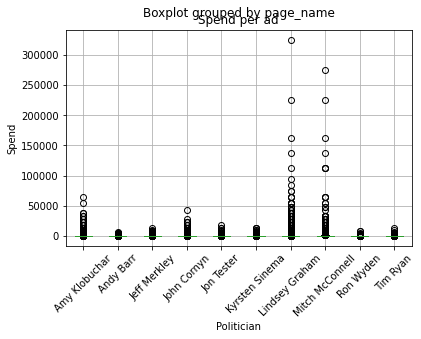

In [5]:
# Boxplot showing outliers of top 10 politicians spending per ads
import matplotlib.pyplot as plt

ads_top_10.boxplot(by='page_name', column=['spend'], rot=45)
plt.xlabel("Politician")
plt.ylabel('Spend')
plt.title('Spend per ad')

In [10]:
# Display spendings range
# https://swdevnotes.com/python/2020/display-line-chart-range/
#  must be specified to be able to use methods of package
import sys
sys.path.append('../src') 
from political_ads.preprocessor import Preprocessor

preprocess = Preprocessor()

# Test with lindsey graham
politician = ads_top_10[ads_top_10["page_name"] == "Ron Wyden"]

politician_grouped_by_day =  preprocess.group_by_day(politician)

# plt.plot(x=politician["ad_creation_time"])
politician.head(1)

,ad_creation_time,ad_creative_body,spend,impressions,delivery_by_region,demographic_distribution,page_id,page_name,bylines,id,spend_lo,spend_hi,impressions_lo,impressions_hi
77718,2021-09-30,It’s time for billionaires to pay their fair s...,49.5,499.5,NaN,NaN,54787697857,Ron Wyden,WYDEN FOR SENATE,187993766686346,0,99,0,999


In [14]:
politician_grouped_by_day_new =  politician.groupby("ad_creation_time").agg(
            # Aggregate no of ads
            no_ads = ('id', 'count'),
            # Aggregate sum of spend & total impressions generated
            sum_spend_lo = ('spend_lo', 'sum'),
            sum_spend_hi = ('spend_hi', 'sum'),
            median_spend = ('spend', 'median'),
            avg_spend = ('spend', lambda x: x.sum()/x.count()),
            sum_impressions_lo = ('impressions_lo', 'sum'),
            sum_impressions_hi = ('impressions_hi', 'sum'),
            # Average number of impressions & spend per ad
            avg_impressions = ('impressions', 'mean')

        ).reset_index().sort_values(by="ad_creation_time", ascending=True)

In [15]:
politician_grouped_by_day_new

,ad_creation_time,no_ads,sum_spend_lo,sum_spend_hi,median_spend,avg_spend,sum_impressions_lo,sum_impressions_hi,avg_impressions
0,2017-08-01,119,2000,13781,49.5,66.306723,247000,417881,2793.617647
1,2017-08-15,27,0,2673,49.5,49.500000,0,26973,499.500000
2,2018-01-19,12,400,1588,49.5,82.833333,32000,51988,3499.500000
3,2018-05-11,16,9600,12784,499.5,699.500000,407000,477984,27655.750000
4,2018-05-17,6,400,994,49.5,116.166667,24000,33994,4832.833333
...,...,...,...,...,...,...,...,...,...
67,2021-07-29,4,200,596,49.5,99.500000,17000,24996,5249.500000
68,2021-08-20,32,800,3968,49.5,74.500000,53000,100968,2405.750000
69,2021-09-13,5,0,495,49.5,49.500000,6000,10995,1699.500000
70,2021-09-24,41,0,4059,49.5,49.500000,6000,46959,645.841463


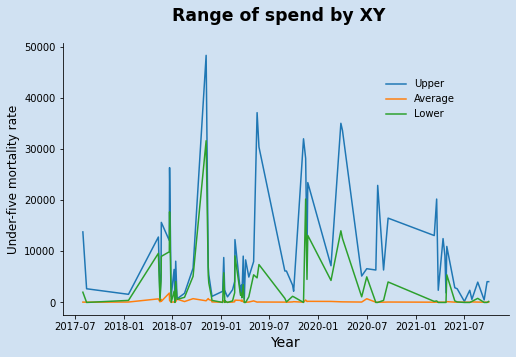

In [8]:
# https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
# This graph: https://swdevnotes.com/python/2020/display-line-chart-range/

politician = 'XY'

# df_c = u5mr_df.loc[([country]), :]
df_c = politician_grouped_by_day
days = df_c.ad_creation_time
lower = df_c.sum_spend_lo
average = df_c.avg_spend
upper = df_c.sum_spend_hi

title = f'Range of spend by {politician}'

fig, ax = plt.subplots(figsize = (8,5), facecolor = plt.cm.Blues(.2))
fig.suptitle(title, fontsize = 'xx-large',  fontweight = 'bold')

ax.set_facecolor(plt.cm.Blues(.2))
ax.plot(days, upper, label = 'Upper')
ax.plot(days, average, label = 'Average')
ax.plot(days, lower, label = 'Lower')
ax.legend(bbox_to_anchor = (0.9, 0.9),
          loc = 'upper right',
          frameon = False,
          fontsize = 'medium')
ax.set_ylabel('Under-five mortality rate', fontsize = 'large')
ax.set_xlabel('Year', fontsize=14)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [28]:
no_ads = by_page["no_ads"].sum()
no_sites = len(by_page)
print(f"Dataset contains {no_sites} pages with total of {no_ads} ads.")
ads_per_page = no_ads/no_sites
total_appr = int(538 * ads_per_page)
print(f"Therefore whole dataset contains appr. {total_appr} ads")

Dataset contains 161 pages with total of 96608 ads.
Therefore whole dataset contains appr. 322826 ads


In [6]:
import sys
sys.path.append('../src') 
from political_ads.preprocessor import Preprocessor

preprocess = Preprocessor()

data = preprocess.file_to_df("..\\data\\all_politicians_aggregated.txt")

In [9]:
data.shape

(342413, 14)

In [15]:
data[data["ad_creative_body"].str.contains("Climate change | climate change", na=False)]

,ad_creation_time,ad_creative_body,spend,impressions,delivery_by_region,demographic_distribution,page_id,page_name,bylines,id,spend_lo,spend_hi,impressions_lo,impressions_hi
295,2019-11-22,Climate change is hurting our communities and ...,649.5,47499.5,"[{'percentage': '0.000351', 'region': 'Kansas'...","[{'percentage': '0.000336', 'age': '18-24', 'g...",983573491675080,Grace Meng,GRACE FOR NEW YORK,2919477421415464,600,699,45000,49999
296,2019-11-22,Climate change is hurting our communities and ...,149.5,12499.5,"[{'percentage': '0.000354', 'region': 'West Vi...","[{'percentage': '0.001005', 'age': '55-64', 'g...",983573491675080,Grace Meng,GRACE FOR NEW YORK,416312259306104,100,199,10000,14999
300,2019-11-07,Climate change is the most pressing issue of o...,649.5,47499.5,"[{'percentage': '0.000121', 'region': 'North D...","[{'percentage': '0.000119', 'age': '18-24', 'g...",983573491675080,Grace Meng,GRACE FOR NEW YORK,2545037148907191,600,699,45000,49999
308,2019-11-07,Climate change is the most pressing issue of o...,2249.5,162499.5,"[{'percentage': '7.5E-5', 'region': 'Vermont'}...","[{'percentage': '7.4E-5', 'age': '13-17', 'gen...",983573491675080,Grace Meng,GRACE FOR NEW YORK,456602951635291,2000,2499,150000,174999
316,2019-11-06,Climate change is the most pressing issue of o...,49.5,1499.5,"[{'percentage': '0.000907', 'region': 'Arkansa...","[{'percentage': '0.177046', 'age': '25-34', 'g...",983573491675080,Grace Meng,Grace for New York,489202311938505,0,99,1000,1999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342147,2021-07-30,Wildfires. Deadly heat waves. Extreme weather ...,49.5,499.5,NaN,NaN,47918118982,Karen Bass,Karen Bass for Congress,140798874863581,0,99,0,999
342148,2021-07-30,Wildfires. Deadly heat waves. Extreme weather ...,49.5,499.5,"[{'percentage': '1', 'region': 'California'}]","[{'percentage': '0.033457', 'age': '45-54', 'g...",47918118982,Karen Bass,Karen Bass for Congress,578444616868691,0,99,0,999
342152,2021-07-30,Wildfires. Deadly heat waves. Extreme weather ...,49.5,499.5,NaN,NaN,47918118982,Karen Bass,Karen Bass for Congress,338853091048013,0,99,0,999
342153,2021-07-30,Wildfires. Deadly heat waves. Extreme weather ...,49.5,499.5,"[{'percentage': '1', 'region': 'California'}]","[{'percentage': '0.001401', 'age': '55-64', 'g...",47918118982,Karen Bass,Karen Bass for Congress,566685434463327,0,99,0,999
